In [11]:
from datetime import datetime
import json
import keyring
import requests

import fitbit
import gather_keys_oauth2 as Oauth2
import pandas as pd 
from pprint import pprint
import matplotlib.pyplot as plt

First we have to set up authorization for the FitBit API. These instructions show you how to set up Fitbit so that you can connect to their api. 

https://towardsdatascience.com/collect-your-own-fitbit-data-with-python-ff145fa10873

At the moment, the first chunk of the code in this notebook is copied directly from this post.


When the directions mention secrets and keys, you'll notice that the code has in this notebook has stored the key and secret using the keyring library. This library helps you manage your keys and IDs (so that if you share your code, you don't share your credentials!).

Here's a great link on how/why to use the keyring library.

https://alexwlchan.net/2016/11/you-should-use-keyring/

One last thing to note is that while we import the fitbit library, we're really only using it for authentication. In other words, we stop following the instruction after step two. Why is this? The fitbit python library calls the fitbit api in units of one day. And the fitbit api limits a single user's calls to 150 per hour, which means that if we used this library, we'd be limited to grabbing only 5 months of data at a time. 

Instead, we're going to create some functions that interact directly with the fitbit API so that we can grab a range of days' worth of data at a time.

To be clear, sometimes you might want to get a single day's worth of data (and there's some code that does exactly that at the bottom of this notebook, but for this analysis, I'm more interested in trends across days than within days.


In [2]:
CLIENT_ID = keyring.get_password("fitbit", "key")
CLIENT_SECRET = keyring.get_password("fitbit", "secret")

server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

[22/May/2018:00:41:52] ENGINE Listening for SIGTERM.
[22/May/2018:00:41:52] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[22/May/2018:00:41:52] ENGINE Set handler for console events.
[22/May/2018:00:41:52] ENGINE Started monitor thread 'Autoreloader'.
[22/May/2018:00:41:52] ENGINE Serving on http://127.0.0.1:8080
[22/May/2018:00:41:52] ENGINE Bus STARTED


127.0.0.1 - - [22/May/2018:00:41:57] "GET /?code=5cc62e57278d42c1c0a3d38dd2d8aabd5df8bc4a&state=CppK4unDLk7twHSLkbGhfKxeupFevH HTTP/1.1" 200 122 "" "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36"


[22/May/2018:00:41:58] ENGINE Bus STOPPING
[22/May/2018:00:42:03] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[22/May/2018:00:42:03] ENGINE Stopped thread 'Autoreloader'.
[22/May/2018:00:42:03] ENGINE Removed handler for console events.
[22/May/2018:00:42:03] ENGINE Bus STOPPED
[22/May/2018:00:42:03] ENGINE Bus EXITING
[22/May/2018:00:42:03] ENGINE Waiting for child threads to terminate...
[22/May/2018:00:42:03] ENGINE Bus EXITED
[22/May/2018:00:42:03] ENGINE Waiting for thread Thread-19.


Now we're authorized to pull data from the Fitbit API. If you've never interacted with an api before, that won't keep you from moving forward with this analysis. Here's the only pieces of information you'll need to understand for this analysis:

1. APIs are tools that entities to provide to allow your program to connect directly to their data. It's how we request data instead of using a UI interface. In Fitbit's case, the API provides more complete and detailed access to your data than is available in the UI download interface.

2. APIs let you 'get', 'post', 'delete', and 'patch'(edit) data. We'll only 'get' data, using the python 'requests' library.

3. Well-designed APIs use consistent URL formats to structure API calls. This takes the form of a URL. Getting, posting (etc.) data involves:
    1. using the correct verb from the requests library (get, post, etc.)
    2. structuring the text of the URL to meet the pattern that the API in question uses.


Here's an example URL from the Fitbit api
 "https://api.fitbit.com/1.2/user/-/sleep/date/2018-04-02/2018-04-08.json"
 
This breaks down into the following pattern:

"https://api.fitbit.com/1.2/user/-/" + endpoint + "/date/" + start_date + "/" + end_date + ".json"

We'll use this to build a generic function that takes the endpoint name, start_date, and end_date.

In [3]:
# getEndpointData is a generic function that lets us retrieve data from any fitbit api endpoint we want
def getEndpointData(endpoint, start_date, end_date):
    # At some point, we should insert some defensive coding here to make sure that the start_date and 
    # end_date are provided in the proper format (YYYY-MM-DD e.g. '2018-04-28'). For now, we'll 
    # leave it to the user to know the correct format
    
    url = "https://api.fitbit.com/1.2/user/-/" + endpoint + "/date/" + start_date + "/" + end_date + ".json"
    results = requests.get(url = url, headers={'Authorization':'Bearer ' + ACCESS_TOKEN})
    if results.status_code == 200:
        activity_data = json.loads(results.text)
        return activity_data
    else:
        print(results.text)
        return "ERROR"
    

Let's also build a function that makes our initial dates go backwards in time. This gives us an an easy way to loop back through all of the data we have stored in fitbit for a given endpoint.

In [4]:
# right now this is set to assume we're pulling one month at a time. That's something 
# that it will probably make sense to change in the future.
import datetime

def makeDatesEarlier(start_date, end_date):
    end_date = (datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
    start_date = (datetime.datetime.strptime(start_date, "%Y-%m-%d") - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
    return start_date, end_date

Now let's try this out with some sleep data!

In [5]:
endpoint = "sleep"

end_date = "2018-04-28"
start_date = "2018-03-29"

activity_data = getEndpointData(endpoint, start_date, end_date)

In [6]:
def processSleepResults(activity_data, sleep_summaries, sleep_time_events_detail):

    if not activity_data['sleep']:
        # sleep endpoint no longer returns results
        print("no more sleep data!")
        return sleep_summaries, sleep_time_events_detail, "stop"
    else:
        for sleep_event in activity_data['sleep']:
            sleep_time_events_detail.append(sleep_event['levels']['data'])
            del sleep_event['levels']['data']
            try: 
                del sleep_event['levels']['shortData']
            except:
                pass
                #this was a nap, so no shortData was available
            sleep_summaries.append(sleep_event)
    return sleep_summaries, sleep_time_events_detail, "continue"

In [7]:
sleep_time_events_detail = []
sleep_summaries = []
endpoint = "sleep"


# start_date decrement month by 1, increment date by 1 
end_date = "2018-05-19"
start_date = "2018-04-20"
    
status = "continue"
    
while status == "continue":
    activity_data = getEndpointData(endpoint, start_date, end_date)
    if activity_data != "ERROR":
        sleep_summaries, sleep_time_events_detail, status = processSleepResults(activity_data, sleep_summaries, sleep_time_events_detail)
        start_date, end_date = makeDatesEarlier(start_date, end_date)
        print("start date: {}, end date: {}".format(start_date, end_date))
    else:
        break

start date: 2018-03-21, end date: 2018-04-19
start date: 2018-02-19, end date: 2018-03-20
start date: 2018-01-20, end date: 2018-02-18
start date: 2017-12-21, end date: 2018-01-19
start date: 2017-11-21, end date: 2017-12-20
start date: 2017-10-22, end date: 2017-11-20
start date: 2017-09-22, end date: 2017-10-21
start date: 2017-08-23, end date: 2017-09-21
start date: 2017-07-24, end date: 2017-08-22
start date: 2017-06-24, end date: 2017-07-23
start date: 2017-05-25, end date: 2017-06-23
start date: 2017-04-25, end date: 2017-05-24
no more sleep data!
start date: 2017-03-26, end date: 2017-04-24


In [ ]:
pprint((sleep_summaries))

In [8]:
# collect date of end sleep time, which will always be the day after the activity time

# for each sleep record, grab the 'endTime' and minutes_asleep, and deep_minutes - ['levels']['summary']['deep']['minutes']

sleep_list = []

#open question: naps?



# make note later about disappointing 30-day-average bs

for sleep_summary in sleep_summaries:
    end_time = sleep_summary['endTime']
    end_date, wakeup_time = end_time.split("T")
    #convert end_date to a date instead of string
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")- datetime.timedelta(days=1)
    minutes_asleep = sleep_summary['minutesAsleep']
    sleep_efficiency = sleep_summary['efficiency']
    try:
        deep_minutes = sleep_summary['levels']['summary']['deep']['minutes']
        deep_count = sleep_summary['levels']['summary']['deep']['count']
        
        light_minutes = sleep_summary['levels']['summary']['light']['minutes']
        light_count = sleep_summary['levels']['summary']['light']['count']
        
        
        rem_minutes = sleep_summary['levels']['summary']['rem']['minutes']
        rem_count = sleep_summary['levels']['summary']['rem']['count']        
        
        wake_minutes = sleep_summary['levels']['summary']['wake']['minutes']
        wake_count = sleep_summary['levels']['summary']['wake']['count']
        
        sleep_list.append({'end_date': end_date, 'wakeup_time': wakeup_time, 'minutes_asleep': minutes_asleep,\
                          'deep_minutes': deep_minutes, 'deep_count': deep_count, \
                           'light_minutes': light_minutes, 'light_count': light_count, \
                           'rem_minutes': rem_minutes, 'rem_count': rem_count, \
                           'wake_minutes': wake_minutes, 'wake_count': wake_count, \
                           'efficiency': sleep_efficiency
                          
                          })
    except:
        # we're skipping nap data
        pass

In [9]:
sleep_df = pd.DataFrame(sleep_list)
print(sleep_df)

     deep_count  deep_minutes  efficiency   end_date  light_count  \
0             3            68          95 2018-05-18           23   
1             1            25         100 2018-05-17           27   
2             2            45          93 2018-05-16           19   
3             3            63          98 2018-05-15           26   
4             5            88          98 2018-05-14           26   
5             2            38          96 2018-05-13           23   
6             2            39          97 2018-05-12           32   
7             4            76          97 2018-05-11           24   
8             4            60          95 2018-05-10           26   
9             2            39          96 2018-05-09           14   
10            3            29          96 2018-05-08           26   
11            3            46          97 2018-05-07           17   
12            5            53          97 2018-05-06           26   
13            5            42     

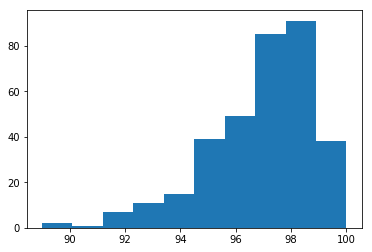

In [12]:
plt.hist(sleep_df['efficiency'])
plt.show()

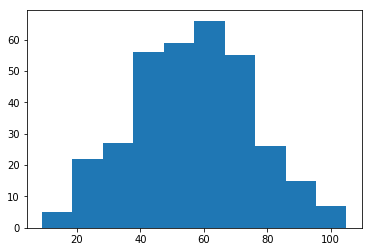

In [13]:
plt.hist(sleep_df['deep_minutes'])
plt.show()

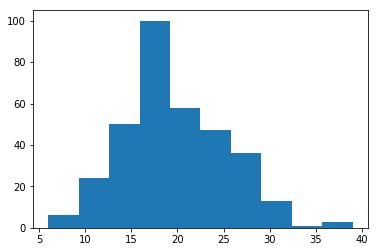

In [14]:
plt.hist(sleep_df['wake_count'])
plt.show()

In [15]:
sleep_df[sleep_df['efficiency'] < 92]

,deep_count,deep_minutes,efficiency,end_date,light_count,light_minutes,minutes_asleep,rem_count,rem_minutes,wake_count,wake_minutes,wakeup_time
60,4,68,91,2018-03-19,25,243,424,7,113,23,49,07:01:30.000
115,3,30,89,2018-01-23,19,283,382,5,69,16,74,06:53:00.000
140,1,44,90,2017-12-29,14,267,386,3,75,13,85,09:46:30.000


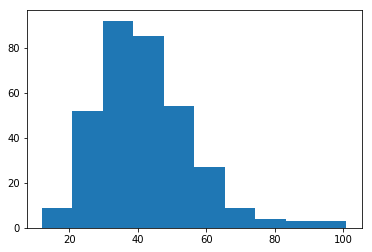

In [16]:
plt.hist(sleep_df['wake_minutes'])
plt.show()

Our question: How is sleep impacted by activity level?

veryActiveMinutes and fairlyActiveMinutes is how we're measuring activity level

Do I have more deep sleep the more I am very and fairly active

In [17]:
def convertActiveMinuteData(data, endpoint):
    data_list = []
    
    endpoint = endpoint.replace(r"/", "-")
    column_name = endpoint.split("-")[1]
    for line in data[endpoint]:
        data_list.append({'end_date': datetime.datetime.strptime(line['dateTime'], "%Y-%m-%d"), column_name: int(line['value'])})
    df = pd.DataFrame(data_list)
    return df

In [18]:
# list of activities endpoints for reference

endpoints = ["activities/calories", "activities/caloriesBMR", "activities/steps", "activities/distance", 
             "activities/floors", "activities/elevation", "activities/minutesSedentary", 
             "activities/minutesLightlyActive", "activities/minutesFairlyActive", "activities/minutesVeryActive",
            "activities/activityCalories"]



In [20]:
import datetime

start_date = '2017-06-10' 
end_date = '2018-05-19'



endpoint = "activities/minutesVeryActive"

# first grab veryActiveMinutes
veryActiveData = getEndpointData(endpoint, start_date, end_date)

# grab date and minutes from veryActiveMinutes
veryActiveList = convertActiveMinuteData(veryActiveData, endpoint)

# then grab fairlyActiveMinutes
endpoint = "activities/minutesFairlyActive"
fairlyActiveData = getEndpointData(endpoint, start_date, end_date)

#grab date and minutes from fairlyActiveMinutes
fairlyActiveList = convertActiveMinuteData(fairlyActiveData, endpoint)


endpoint = "activities/minutesSedentary"
sedentaryActiveData = getEndpointData(endpoint, start_date, end_date)

#grab date and minutes from fairlyActiveMinutes
sedentaryActiveList = convertActiveMinuteData(sedentaryActiveData, endpoint)



endpoint = "activities/minutesLightlyActive"
lightlyActiveData = getEndpointData(endpoint, start_date, end_date)

#grab date and minutes from fairlyActiveMinutes
lightlyActiveList = convertActiveMinuteData(lightlyActiveData, endpoint)

In [21]:
# activity score. 
# dailyminutes (1440) = sedentaryMinutes + all active minutes

# of the waking time, how much was active, and how much was sedentary?

# use average number of asleep minutes - 407 to subtract from sedentaryMinutes and dailyMinutes

# what percentage of time was I active (out of awake minutes)?
# all_active_minutes / (1440-407)

# all_active_minutes / 1033

def calculatePercent(input_list, target):
    return target / sum(input_list) 




In [22]:
activity_data = pd.merge(veryActiveList, fairlyActiveList, on='end_date')
activity_data = pd.merge(activity_data, sedentaryActiveList, on='end_date')
activity_data = pd.merge(activity_data, lightlyActiveList, on='end_date')
activity_data = pd.merge(activity_data, sleep_df, on='end_date')

activity_data = activity_data.fillna(0)

print(activity_data)

# Investigate data further using Tableau

      end_date  minutesVeryActive  minutesFairlyActive  minutesSedentary  \
0   2017-06-10                 45                   28               671   
1   2017-06-11                 49                   17               837   
2   2017-06-12                 27                   26               873   
3   2017-06-13                 21                   33               807   
4   2017-06-14                 46                   36               841   
5   2017-06-15                 67                   43               780   
6   2017-06-16                 45                   46               699   
7   2017-06-17                  0                    0               757   
8   2017-06-18                  2                    9               728   
9   2017-06-19                 56                    7               797   
10  2017-06-20                  9                   53               782   
11  2017-06-21                 42                   24               806   
12  2017-06-

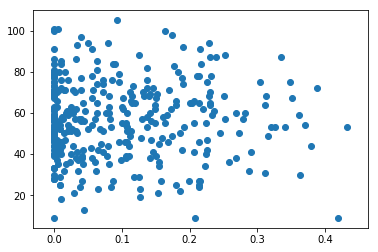

In [23]:
# Trying to see if very_active_minutes taken as a percent of total active time are 
# able to predict deep sleep


activity_data['very_active_percent'] = activity_data.apply(lambda x: calculatePercent([x['minutesLightlyActive'], x['minutesVeryActive'], x['minutesFairlyActive']], x['minutesVeryActive']), axis = 1)



plt.scatter(activity_data['very_active_percent'], activity_data['deep_minutes'])
plt.show()

It would seem that very_active_minutes are not a good predictor of the number of deep sleep minutes.

Do very active minutes decrease the number of waking events during the night?



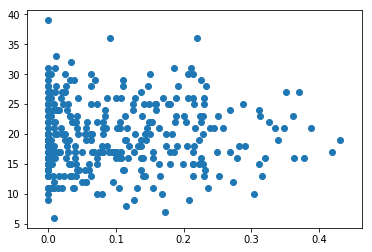

In [24]:

plt.scatter(activity_data['very_active_percent'], activity_data['wake_count'])
plt.show()

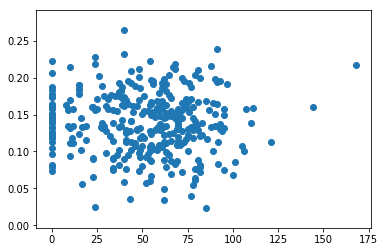

In [27]:
plt.scatter((activity_data['minutesVeryActive']+activity_data['minutesFairlyActive']),activity_data['deep_minutes']/activity_data['minutes_asleep'])
plt.show()



Below we have some code Melissa wrote to originally interact with the fitbit library (the one that runs into that 150 calls per hour limit.)  We're keeping the code here in case it's helpful as we're building out the other data sets.

In [ ]:
#yesterday2 = str((datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d"))
#today = str(datetime.now().strftime("%Y%m%d"))

#yesterday2 = ((datetime.now() - timedelta(days=1)))
#yesterday3 = (yesterday2 - timedelta(days=1))
#print(yesterday3)

current_day = "2018-05-18"


'''
These functions use the intra-day endpoint. 

CAUTION: Plan your calls wisely, or you will exceed 150 API calls per hour.

'''

#take a starting date and a total number of days as an input
# day needs to be in YYYY-MM-DD format
def pullFitBitData(start_date, days, call_type):
    #insert date error checking laterz
    print("Processing day: {}".format(start_date))
    current_date = start_date
    activity_df, heartRate_df = buildActivityData(current_date)
    day_counter = 0
    while day_counter < days:
        current_date = (datetime.datetime.strptime(current_date, "%Y-%m-%d") - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
        print("Processing day: {}".format(current_date))
        activity_df2, heartRate_df2 = buildActivityData(current_date)
        activity_df = pd.concat([activity_df, activity_df2])
        heartRate_df = pd.concat([heartRate_df, heartRate_df2])
        day_counter += 1
    print("Ended processing on {}.".format(current_date))
    return activity_df, heartRate_df
        

In [ ]:
with open('sleep_time_events_detail.txt', 'w') as outfile:
    json.dump(sleep_time_events_detail, outfile)

In [ ]:
fit_statsHR = auth2_client.intraday_time_series('activities/heart', base_date=current_day, detail_level='15min')
heartRateZones = (fit_statsHR['activities-heart'][0]['value']['heartRateZones'])

'''
column_names = heartRatePivot_df.columns.values
new_column_names = []
for name in column_names:
    new_name = name[1].replace(' ', '_')+'.'+name[0]
    new_column_names.append(new_name)
heartRatePivot_df.columns = new_column_names
print(heartRatePivot_df)
'''


def accumulateHeartData(current_day, heartRateZones):
    date_dict = {'date': [current_day, current_day, current_day, current_day]}
    date_df = pd.DataFrame(date_dict)
    
    heartRateZones_df = pd.DataFrame.from_records(heartRateZones)
    heartRateZones_df['date'] = date_df['date']
    heartRatePivot_df = heartRateZones_df.pivot(index='date', columns='name')
    column_names = heartRatePivot_df.columns.values
    new_column_names = []
    for name in column_names:
        new_name = name[1].replace(' ', '_')+'.'+name[0]
        new_column_names.append(new_name)
    heartRatePivot_df.columns = new_column_names
    return heartRatePivot_df

def buildActivityData(current_date):
    activity_stats = auth2_client.activities(date=current_date)
    pprint(activity_stats)
    activity_stats = activity_stats['summary']
    heartRateZones = activity_stats['heartRateZones']
    heartRate_df = accumulateHeartData(current_date, heartRateZones)
    del activity_stats['distances']
    del activity_stats['heartRateZones']
    activity_df = pd.DataFrame(activity_stats, index=[current_date])
    return activity_df, heartRate_df

In [ ]:
activity_df, heartRate_df = buildActivityData("2018-05-18")

In [ ]:
print(activity_df)

In [ ]:
print(heartRate_df)

In [ ]:
fit_statsHR = auth2_client.intraday_time_series('activities/heart', base_date=current_day, detail_level='15min')
pprint(fit_statsHR)